<table style="width: 100%;"> <tr> <td style="width: 20%; vertical-align: top;"> <img src="https://scontent.fpei1-1.fna.fbcdn.net/v/t39.30808-6/241998866_100151369093866_8422142037584747656_n.png?_nc_cat=105&ccb=1-7&_nc_sid=6ee11a&_nc_ohc=FchCmU1e1gEQ7kNvwE89YIg&_nc_oc=AdmQ9y67Ecx1BB_nvddzennfiXVsBDvNrPJ5hqlDinea5QAvxjZNtXsMhz8DDsDgyFy4H1vrFQA7trFxEm5y6Prv&_nc_zt=23&_nc_ht=scontent.fpei1-1.fna&_nc_gid=_d-S8PdbAXYSs7VxpPTPSw&oh=00_AfOBC8aP7NU5m3RyP6R5wA65f3f0nE-5y5EsdJgBLz-7Ww&oe=6864C04D"ASOCIO" height="150px"> </td> <td style="width: 80%; padding-left: 20px;"> <strong style="font-size: 30px;">STUDENT CHALLENGE'25: ASIGNACIÓN DE PUESTOS DE TRABAJO PARA UNA ESTRATEGÍA HIBRIDA DE PRESENCIALIDAD Y TELETRABAJO </strong><br><br> <span style="font-size: 30px;"> Valentina Jiménez Torres <br> Juan Camilo Henao Caro<br> Fernando Antonio Piñeres Ramos <br> <i>Estudiantes de ingeniería industrial <i>  <br> <i> Universidad de Antioquia <i> </span> </td> </tr> </table>




#### **DESCRIPCIÓN DEL PROBLEMA**

Desde 2022, la Dirección de Planeación y Desarrollo Institucional adoptó un **modelo de teletrabajo híbrido**, permitiendo a los colaboradores combinar el trabajo remoto con jornadas presenciales. **El cambio ha generado un nuevo reto logístico: la asignación de puestos de trabajo compartidos**. Actualmente, este proceso se realiza de forma manual, lo que consume mucho tiempo y dificulta la adaptación a cambios de último minuto, como ausencias inesperadas.

El objetivo es crear una **solución automatizada para optimizar la asignación de puestos de trabajo**. Para ello, se desarrolló un **modelo de optimización en Python** que distribuirá los espacios de manera equitativa y eficiente, considerando las necesidades de los colaboradores y la estructura de la Dirección.

#### 1. PREPARACIÓN DEL ENTORNO

##### **1.1 INSTALACIÓN E IMPORTE DE LIBRERÍAS**

In [1]:
#PuLP es una librería de python que se utiliza para modelar y resolver problemas de optimización, especialmente problemas de PL y PE.
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 55.4 MB/s eta 0:00:00


In [2]:
#Importe de librerías requeridas.
from google.colab import files #Permite seleccionar y subir archivos desde la computadora local a Colab.
import json # Permite trabajar con datos en formato JSON (JavaScript Object Notation).
#import random #Se utiliza para generar números aleatorios o realizar selecciones aleatorias.
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, LpStatus, LpBinary

Funciones Clave de PuLP
- LpProblem: Crea el modelo de optimización completo.
- LpVariable: Define las variables de decisión (ej. si un empleado va a un puesto).
- LpMaximize: Establece que el objetivo es maximizar un valor (ej. la satisfacción).
- lpSum: Permite hacer sumas eficientes para las restricciones y el objetivo.
- LpStatus: Verifica el estado de la solución (ej. si es óptima).
- LpBinary: Limita las variables a valores binarios (0 o 1), ideal para problemas de asignación.

















##### **1.2 LECTURA DE LAS INSTANCIAS DE DATOS**

In [5]:
uploaded = files.upload()
filename = next(iter(uploaded))

Saving instance1.json to instance1.json


In [6]:
with open(filename) as f:
    data = json.load(f)

#### 2. FORMULACIÓN DEL MODELO DE ASIGNACIÓN

##### **2.1 DEFINICIÓN DE LOS CONJUNTOS Y PARÁMETROS**

In [7]:
# Conjuntos
E = data['Employees']
D = data['Desks']
S = data['Days']
G = data['Groups']
Z = data['Zones']

# Parámetros
DesksZ_raw = data['Desks_Z'] #Escritorios por zona
DesksE = data['Desks_E']  #Escritorios por día
EmployeesG = data['Employees_G'] #Colaboradores por grupo
DaysE_orig = data['Days_E']  #Días preferidos por cada colaborador

In [8]:
# Mínimo 2 días presenciales por empleado; un 3er día solo si hay espacio
total_slots = len(D) * len(S)
min_required = 2 * len(E)
max_extra = total_slots - min_required

In [9]:
DesksZ = {}
for zonadesk, desks in DesksZ_raw.items():
    for d in desks:
        DesksZ[d] = zonadesk

##### **2.2 DEFINICIÓN DE LAS VARIABLES DE DECISIÓN**


In [10]:
model = LpProblem("Asignacion_Hibrida", LpMaximize)

# Variables
x = LpVariable.dicts("x", (E, D, S), cat=LpBinary)
z = LpVariable.dicts("z", (E, S), cat=LpBinary)
y = LpVariable.dicts("y", (G, S), cat=LpBinary)
w = LpVariable.dicts("w", (G, Z, S), cat=LpBinary)

In [11]:
u = LpVariable.dicts("u", (G, E, S), cat=LpBinary)  # z ∧ y
extra = LpVariable.dicts("extra", E, cat=LpBinary)

##### **2.3 DEFINICIÓN DE RESTRICCIONES**


In [12]:
# R1: compatibilidad de escritorios (ya no limitamos días preferidos)
for e in E:
    for d in D:
        for s in S:
            if d not in DesksE[e]:
                model += x[e][d][s] == 0

# R3: un escritorio por día y empleado
for e in E:
    for s in S:
        model += lpSum(x[e][d][s] for d in D) <= 1

# R4: un escritorio no se comparte
for d in D:
    for s in S:
        model += lpSum(x[e][d][s] for e in E) <= 1

# R5: asignar 2 días por empleado, y un 3ro solo si extra[e] = 1
for e in E:
    model += lpSum(z[e][s] for s in S) >= 2
    model += lpSum(z[e][s] for s in S) <= 2 + extra[e]
model += lpSum(extra[e] for e in E) <= max_extra

# R6: un día de reunión por grupo
for g in G:
    model += lpSum(y[g][s] for s in S) == 1

# Eliminamos R7: ya no forzamos cobertura 100%

# R8: Solo permitir w[g][z][s] = 1 si hay reunión y alguien del grupo se sienta allí
for g in G:
    for s in S:
        for z_id in Z:
            empleados = EmployeesG[g]
            escritorios_en_zona = [d for d in D if DesksZ[d] == z_id]

            # Si alguien del grupo se sienta en esa zona el día de reunión, w = 1
            model += lpSum(x[e][d][s] for e in empleados for d in escritorios_en_zona) <= len(escritorios_en_zona) * w[g][z_id][s]

            # También, si w = 1, entonces al menos una persona se sentó ahí
            model += lpSum(x[e][d][s] for e in empleados for d in escritorios_en_zona) >= w[g][z_id][s]

# R9: ligar presencia y asignación de escritorio
for e in E:
    for s in S:
        model += lpSum(x[e][d][s] for d in D) == z[e][s]

# # R10: zonas sólo si hay reunión
# for g in G:
#     for z_id in Z:
#         for s in S:
#             model += w[g][z_id][s] <= y[g][s]

In [13]:
# R11: linealización de u[g,e,s] = z[e,s] ∧ y[g,s]
for g in G:
    for s in S:
        for e in EmployeesG[g]:
            model += u[g][e][s] <= z[e][s]
            model += u[g][e][s] <= y[g][s]
            model += u[g][e][s] >= z[e][s] + y[g][s] - 1

##### **2.4 DEFINICIÓN DE LA FUNCIÓN OBJETIVO**


In [14]:

alpha_orig = 2.0   # peso por día preferido
alpha_fill = 0.5   # peso por día no preferido
beta       = 1.2   # premio por reunión
gamma      = 0.5   # penalización por múltiples zonas
theta      = 1.0   # premio por cobertura de reunión

# Premio por asignar en días originales
orig_term = lpSum(
    alpha_orig * z[e][s]
    for e in E for s in DaysE_orig[e]
)

# Premio menor por días no preferidos
fill_term = lpSum(
    alpha_fill * z[e][s]
    for e in E for s in S if s not in DaysE_orig[e]
)

# Premio por reunión bien planificada y miembros asistiendo
meet_term   = beta  * lpSum(y[g][s] for g in G for s in S)
cover_term  = theta * lpSum(u[g][e][s] for g in G for e in EmployeesG[g] for s in S)

# Penalización por múltiples zonas en una reunión
zone_term = -gamma * lpSum(w[g][z_id][s] for g in G for z_id in Z for s in S)

# Premio por uso de asignaciones extra
bonus_term = 0.1 * lpSum(extra[e] for e in E)

# Objetivo completo
model += orig_term + fill_term + meet_term + cover_term + zone_term + bonus_term

#### 3. RESULTADOS DEL MODELO

In [ ]:
#from pulp import PULP_CBC_CMD
#model.solve(PULP_CBC_CMD(timeLimit=240, msg=True))
#print("Estado:", LpStatus[model.status], "\n")

Estado: Optimal 



In [15]:
# 7. Resolver y mostrar
model.solve()
print("Estado:", LpStatus[model.status], "\n")

Estado: Optimal 



In [16]:
print("\nAsignaciones completas:")
for e in E:
    print(f"\n🔹 Empleado {e}")
    assigned_days = 0
    for s in S:
        if z[e][s].varValue == 1:
            assigned_days += 1
            desk = next((d for d in D if x[e][d][s].varValue == 1), None)
            zone = DesksZ.get(desk, "N/A")
            print(f" ▸ Día {s} — Escritorio {desk} — Zona {zone}")
    print(f"  Total días asignados: {assigned_days}")


Asignaciones completas:

🔹 Empleado E0
 ▸ Día Mi — Escritorio D3 — Zona Z0
 ▸ Día V — Escritorio D6 — Zona Z1
  Total días asignados: 2

🔹 Empleado E1
 ▸ Día Ma — Escritorio D2 — Zona Z0
 ▸ Día Mi — Escritorio D2 — Zona Z0
  Total días asignados: 2

🔹 Empleado E2
 ▸ Día L — Escritorio D1 — Zona Z0
 ▸ Día Ma — Escritorio D3 — Zona Z0
 ▸ Día Mi — Escritorio D0 — Zona Z0
  Total días asignados: 3

🔹 Empleado E3
 ▸ Día L — Escritorio D2 — Zona Z0
 ▸ Día Mi — Escritorio D4 — Zona Z0
  Total días asignados: 2

🔹 Empleado E4
 ▸ Día L — Escritorio D0 — Zona Z0
 ▸ Día Ma — Escritorio D1 — Zona Z0
 ▸ Día Mi — Escritorio D1 — Zona Z0
  Total días asignados: 3

🔹 Empleado E5
 ▸ Día Ma — Escritorio D7 — Zona Z1
 ▸ Día J — Escritorio D0 — Zona Z0
  Total días asignados: 2

🔹 Empleado E6
 ▸ Día Mi — Escritorio D7 — Zona Z1
 ▸ Día J — Escritorio D4 — Zona Z0
  Total días asignados: 2

🔹 Empleado E7
 ▸ Día Ma — Escritorio D5 — Zona Z1
 ▸ Día Mi — Escritorio D5 — Zona Z1
 ▸ Día J — Escritorio D1 — Zona

In [17]:
print("\nZonas activadas y asistencia por grupo en su día de reunión:\n")

for g in G:
    for s in S:
        if y[g][s].varValue == 1:
            zonas_activas = [z_id for z_id in Z if w[g][z_id][s].varValue == 1]
            empleados_presentes = [e for e in EmployeesG[g] if z[e][s].varValue == 1]

            print(f"🔹 Grupo {g} — Día de reunión: {s}")
            print(f"  ▸ Zonas activadas: {', '.join(zonas_activas) if zonas_activas else 'Ninguna'}")
            print(f"  ▸ Empleados presentes: {', '.join(empleados_presentes) if empleados_presentes else 'Ninguno'}\n")


Zonas activadas y asistencia por grupo en su día de reunión:

🔹 Grupo G0 — Día de reunión: Mi
  ▸ Zonas activadas: Z0
  ▸ Empleados presentes: E0, E1, E2, E3, E4

🔹 Grupo G1 — Día de reunión: J
  ▸ Zonas activadas: Z0
  ▸ Empleados presentes: E5, E6, E7, E8, E9

🔹 Grupo G2 — Día de reunión: L
  ▸ Zonas activadas: Z0, Z1
  ▸ Empleados presentes: E10, E11, E13, E14

🔹 Grupo G3 — Día de reunión: V
  ▸ Zonas activadas: Z0
  ▸ Empleados presentes: E15, E16, E17, E18, E19



In [ ]:
print("\nResumen diario de asignaciones:\n")

for s in S:
    empleados_dia = []
    escritorios_dia = []
    zonas_dia = []

    for e in E:
        for d in D:
            if x[e][d][s].varValue == 1:
                empleados_dia.append(e)
                escritorios_dia.append(d)
                zonas_dia.append(DesksZ[d])

    print(f"📅 Día {s}")
    print(f"  ▸ Total empleados asignados: {len(empleados_dia)}")

    if empleados_dia:
        for e, d, z in zip(empleados_dia, escritorios_dia, zonas_dia):
            print(f"    - Empleado {e} → Escritorio {d} (Zona {z})")
    else:
        print("    - No hay asignaciones.")

    print("-" * 40)


Resumen diario de asignaciones:

📅 Día L
  ▸ Total empleados asignados: 45
    - Empleado E2 → Escritorio D19 (Zona Z6)
    - Empleado E4 → Escritorio D24 (Zona Z8)
    - Empleado E10 → Escritorio D9 (Zona Z3)
    - Empleado E13 → Escritorio D34 (Zona Z11)
    - Empleado E17 → Escritorio D4 (Zona Z1)
    - Empleado E18 → Escritorio D13 (Zona Z4)
    - Empleado E19 → Escritorio D7 (Zona Z2)
    - Empleado E20 → Escritorio D14 (Zona Z4)
    - Empleado E21 → Escritorio D36 (Zona Z12)
    - Empleado E23 → Escritorio D38 (Zona Z12)
    - Empleado E25 → Escritorio D20 (Zona Z6)
    - Empleado E26 → Escritorio D42 (Zona Z14)
    - Empleado E27 → Escritorio D41 (Zona Z13)
    - Empleado E30 → Escritorio D18 (Zona Z6)
    - Empleado E31 → Escritorio D21 (Zona Z7)
    - Empleado E32 → Escritorio D15 (Zona Z5)
    - Empleado E33 → Escritorio D23 (Zona Z7)
    - Empleado E34 → Escritorio D22 (Zona Z7)
    - Empleado E36 → Escritorio D40 (Zona Z13)
    - Empleado E45 → Escritorio D5 (Zona Z1)
    

#### MÉTRICAS

In [18]:
# --- A. Satisfacción con días preferidos
preferidos_totales = 0
asignaciones_totales = 0
empleados_completamente_satisfechos = 0

for e in E:
    dias_asignados = [s for s in S if z[e][s].varValue == 1]
    dias_preferidos = DaysE_orig[e]
    preferidos = [s for s in dias_asignados if s in dias_preferidos]
    preferidos_totales += len(preferidos)
    asignaciones_totales += len(dias_asignados)
    if set(dias_asignados).issubset(set(dias_preferidos)):
        empleados_completamente_satisfechos += 1

print(f"🎯 % días asignados preferidos: {100 * preferidos_totales / asignaciones_totales:.2f}%")
print(f"🎯 % empleados con todos los días preferidos: {100 * empleados_completamente_satisfechos / len(E):.2f}%")

# --- B. Consistencia de escritorio
empleados_mismo_escritorio = 0

for e in E:
    escritorios = set()
    for s in S:
        for d in D:
            if x[e][d][s].varValue == 1:
                escritorios.add(d)
    if len(escritorios) == 1:
        empleados_mismo_escritorio += 1

print(f"🔁 % empleados con mismo escritorio todos los días: {100 * empleados_mismo_escritorio / len(E):.2f}%")

# --- C. Uso promedio de escritorios por día
uso_diario = {s: 0 for s in S}
for s in S:
    for d in D:
        for e in E:
            if x[e][d][s].varValue == 1:
                uso_diario[s] += 1

promedio_uso = sum(uso_diario.values()) / len(S)
print(f"📐 Uso promedio de escritorios por día: {promedio_uso:.2f} escritorios")

# --- D. Cohesión por zona en reuniones
grupos_con_unica_zona = 0

for g in G:
    for s in S:
        if y[g][s].varValue == 1:
            zonas_activas = [z for z in Z if w[g][z][s].varValue == 1]
            if len(zonas_activas) == 1:
                grupos_con_unica_zona += 1

print(f"🤝 % reuniones de grupo con todos en una sola zona: {100 * grupos_con_unica_zona / len(G):.2f}%")


🎯 % días asignados preferidos: 86.67%
🎯 % empleados con todos los días preferidos: 70.00%
🔁 % empleados con mismo escritorio todos los días: 10.00%
📐 Uso promedio de escritorios por día: 9.00 escritorios
🤝 % reuniones de grupo con todos en una sola zona: 75.00%


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipython-input-83-3737335212.py:15: UserWarning: Glyph 128306 (\N{BLACK SQUARE BUTTON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128306 (\N{BLACK SQUARE BUTTON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


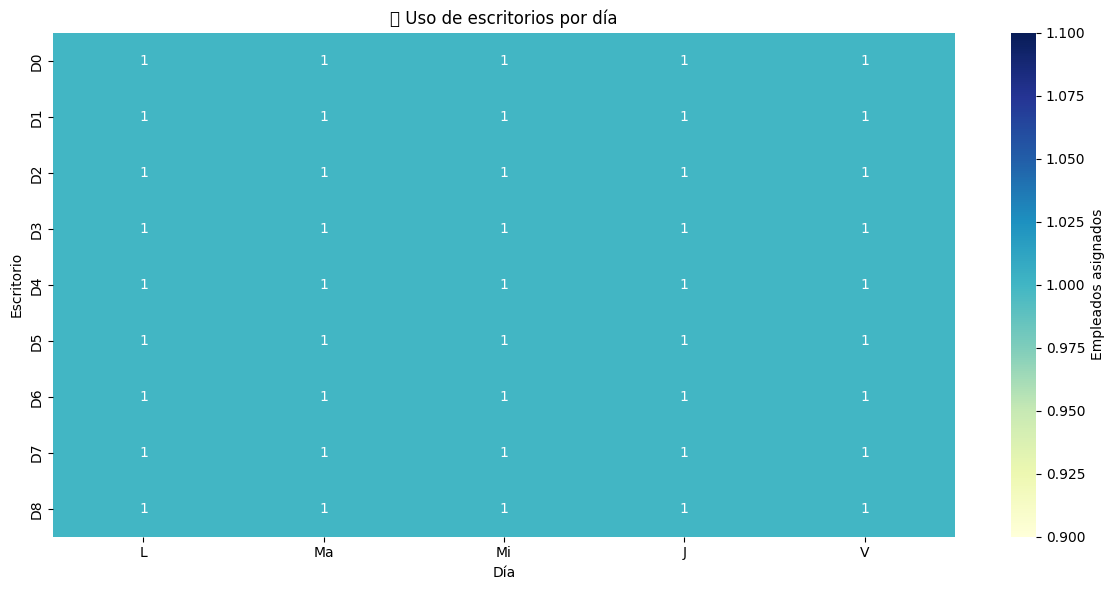

In [ ]:
# Crear DataFrame para el uso diario de escritorios
usage_matrix = pd.DataFrame(0, index=D, columns=S)

for e in E:
    for d in DesksE[e]:
        for s in S:
            if x[e][d][s].varValue == 1:
                usage_matrix.loc[d, s] += 1

plt.figure(figsize=(12, 6))
sns.heatmap(usage_matrix, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Empleados asignados'})
plt.title("🔲 Uso de escritorios por día")
plt.xlabel("Día")
plt.ylabel("Escritorio")
plt.tight_layout()
plt.show()

/tmp/ipython-input-84-3253961223.py:26: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


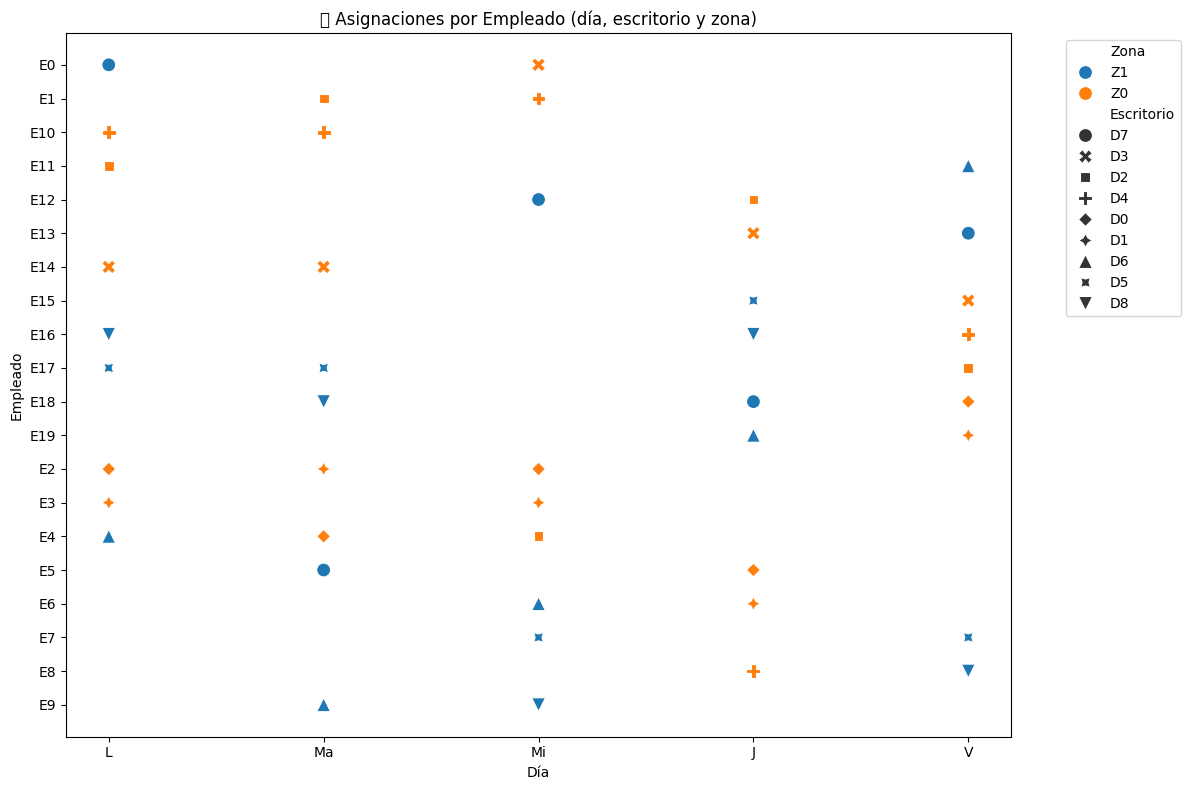

In [ ]:
# DataFrame de asignaciones por empleado
data_gantt = []

for e in E:
    for s in S:
        for d in DesksE[e]:
            if x[e][d][s].varValue == 1:
                zona = DesksZ.get(d, "N/A")
                data_gantt.append({
                    "Empleado": e,
                    "Día": s,
                    "Escritorio": d,
                    "Zona": zona
                })

df_gantt = pd.DataFrame(data_gantt)

# Orden por empleado para claridad
df_gantt["Empleado"] = pd.Categorical(df_gantt["Empleado"], categories=sorted(E), ordered=True)
df_gantt["Día"] = pd.Categorical(df_gantt["Día"], categories=S, ordered=True)

plt.figure(figsize=(12, len(E) * 0.4))
sns.scatterplot(data=df_gantt, x="Día", y="Empleado", hue="Zona", style="Escritorio", s=100)
plt.title("📅 Asignaciones por Empleado (día, escritorio y zona)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
